In [1]:
# Final Version

In [2]:
import math
import random
import numpy as np
from collections import deque

from unityagents import UnityEnvironment

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils
from torch.distributions import Normal

import csv
import time
import datetime

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h1>CUDA</h1>

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h1>Ornstein-Uhlenbeck Process</h1>
Adding time-correlated noise to the actions taken by the deterministic policy<br>
<a href="https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process">wiki</a>

In [5]:
class OUNoise(object):
    
    def __init__(self, action_space_size, mu=0.0, theta=0.15, max_sigma=0.2, min_sigma=0.01, decay_period=100000):

        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period

        self.action_dim   = action_space_size
        self.low          = -1
        self.high         = 1

        self.reset()

    def reset(self):
        
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        
        x  = self.state
        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        
        self.state = x + dx

        return self.state

    def get_action(self, actions, t=0):
        
        ou_state = self.evolve_state()
        #print("ou_state -> ", ou_state)
        
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)

        return np.clip(actions + ou_state, self.low, self.high)


<h1>Replay Buffer</h1>

In [6]:
# 
# ReplayBuffer
#
# Stores experiences agents' interaction with the environment which are afterwards used during the learning process
#
class ReplayBuffer:

    def __init__(self, capacity):

        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):

        if len(self.buffer) < self.capacity:
            self.buffer.append(None)

        self.buffer[self.position] = (state, action, reward, next_state, done)

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):

        # gets a random batch of experiences from the replay buffer 
        batch = random.sample(self.buffer, batch_size)

        # extracts the batch of states, actions, rewards, next_actions and dones into independent arrays
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

<h1>Actor Network</h1>

In [7]:
#
# Actor
#
# receives a state and returns a value for each possible action in that state (allows for continuous action spaces)
#
class ActorNetwork(nn.Module):

    def __init__(self, num_agents, num_inputs, num_actions, hidden_size):
        
        super(ActorNetwork, self).__init__()

        self.num_agents = num_agents
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        
        self.network = nn.Sequential (
            nn.Linear(num_inputs, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size, num_actions),
            nn.BatchNorm1d(num_actions),
            nn.Tanh()
        )

    def forward(self, states):

        # (N x 24)
        #print("\nactor forward input state -> ", states.size())
        
        x = self.network(states)
        
        #print("actor forward output x -> ", x.size()) # (N, 2)
        
        return x
    

<h1>Critic Network</h1>

In [8]:
#
# Critic
#
# receives a state and actions for that state from the actor, and returns its evaluation of it
#
class CriticNetwork(nn.Module):
    
    def __init__(self, num_agents, num_inputs, num_actions, hidden_size):
        
        super(CriticNetwork, self).__init__()

        self.num_agents = num_agents
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        
        self.network = nn.Sequential (
            nn.Linear((num_agents * num_inputs) + (num_agents * num_actions), hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, states, actions):

        #print("\ncritic forward input states -> ", states.size())  # (N, 48)
        #print("critic forward input actions -> ", actions)  # (N, 4)

        # concatenates the states and actions
        x = torch.cat((states, actions), 1)  # (N, 52)
        #print("critic forward x after cat -> ", x.size())
        #print("critic forward x after cat -> ", x)

        x = self.network(x)
        
        #print("critic forward x output -> ", x.size())
        
        return x

<h1>Auxiliary Neural Network Functions</h1>

In [9]:
def hard_update(source_model, target_model):
    for target_param, param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(param.data)
    
def soft_update(source_model, target_model, tau=1e-2):
    for target_param, param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

<h1>Agents Handler</h1>

In [10]:
#
# AgentsHandler
#
# Manages the learning process of all agents
#

# replay buffer contains tuples of experiences from all N agents as follows
# (X, a1,..., aN, X', r1,..., rN) 
# where:
# N is the number of agents
# X is the current observation at time t from all agents
# X' is the next observation at time t from all agents
# a1,..,aN are the actions selected by each agent 
# r1,..., rN are the rewards received by each agent


# useful code references:
# https://github.com/shariqiqbal2810/maddpg-pytorch
# https://github.com/xuehy/pytorch-maddpg/blob/master/MADDPG.py

class AgentsHandler:

    def __init__(self, num_agents, state_dim, action_dim, replay_buffer_size=100000, batch_size=512, hidden_dim=128, critic_lr=1e-3, actor_lr=1e-3):

        # stores the number of agents
        self.num_agents = num_agents
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # instantiates a new shared replay buffer
        self.replay_buffer_size = replay_buffer_size
        self.replay_buffer = ReplayBuffer(self.replay_buffer_size)

        # size of batch of experiments to use when training the agents' actor and critic nextworks
        self.batch_size  = batch_size
        
        # local critic networks
        self.critic_net = [CriticNetwork(num_agents, state_dim, action_dim, hidden_dim).to(device) for i in range(num_agents)]

         # target critic networks
        self.critic_target_net  = [CriticNetwork(num_agents, state_dim, action_dim, hidden_dim).to(device) for i in range(num_agents)]
                                   
        # copies parameter values from the local to the target network
        for i in range(num_agents):
            hard_update(self.critic_net[i], self.critic_target_net[i])
        
        # local actor networks
        self.actor_net = [ActorNetwork(num_agents, state_dim, action_dim, hidden_dim).to(device) for i in range(num_agents)]

        # target actor networks
        self.actor_target_net = [ActorNetwork(num_agents, state_dim, action_dim, hidden_dim).to(device) for i in range(num_agents)]
        
        # copies the initial parameters from the local network to the target network for each agent
        for i in range(num_agents):
            hard_update(self.actor_net[i], self.actor_target_net[i])

        # learning rates
        self.critic_lr  = critic_lr
        self.actor_lr = actor_lr

        # optimisers for each agent
        self.critic_optimizer = [optim.Adam(self.critic_net[i].parameters(),  lr = self.critic_lr) for i in range(num_agents)]
        self.actor_optimizer  = [optim.Adam(self.actor_net[i].parameters(), lr = self.actor_lr) for i in range(num_agents)]

        # loss function for the critic network of each agent
        self.critic_loss = nn.MSELoss()
        #self.critic_loss = nn.SmoothL1Loss()

        # number of steps to take before copying the local networks' parameters to the target networks
        self.actor_target_network_parameter_update_steps = 20
        self.critic_target_network_parameter_update_steps = 20

        # steps to take before learning again
        self.steps_to_learning = 1
        
        # noise function for actions
        self.ou_noise = OUNoise(action_dim)

    def reset_noise(self):

        # resets the noise function of all agents
        self.ou_noise.reset()

    def act(self, states, step):

        #print("\nagents_handler act states input -> ", states.shape)  # (2, 24)
        
        # converts teh received states to a tensor
        states_tensor = torch.FloatTensor(states).to(device)
        
        actions = []
        
        for i in range(self.num_agents):
            
            # no training
            self.actor_net[i].eval()

            # performs a forward pass and retrieves the best values for this agent (1, 2)
            #print("states_tensor[i, :] -> ", states_tensor[i,:].unsqueeze(0).size())
            agent_actions_tensor = self.actor_net[i](states_tensor[i, :].unsqueeze(0))
        
            # moves the actions to cpu
            agent_actions_tensor = agent_actions_tensor.detach().cpu().numpy()
            
            # removes the top dimension introduced by the actor network (1, 1, 2) -> (1, 2)
            agent_actions_tensor = np.squeeze(agent_actions_tensor, axis=0)
            
            # enable training
            self.actor_net[i].train()

            # if training then adds some noise to the agent decided actions to encourage exploration
            if training_mode == True:
                #print("agent_actions before noise -> ", agent_actions_tensor)
                agent_actions_noisy_tensor = self.ou_noise.get_action(agent_actions_tensor, step)
                #print("agent_actions after noise -> ", agent_actions_noisy_tensor)
            else:
                agent_actions_noisy_tensor = agent_actions_tensor

            # adds the actor actions to the final array
            actions.append(agent_actions_noisy_tensor)
            
            #print("agent_actions -> ", agent_actions_noisy_tensor.shape)
  
        # converts actions to a numpy array
        actions = np.array(actions)
        
        #print("agents_handler act states output -> ", actions.shape)
        
        # returns the chosen action (2, 2)
        return actions

    def step(self, step, states, actions, rewards, next_states, dones):
        
        # stores the current experience OF BOTH AGENTS in the SHARED replay buffer (COOPERATION)
        self.replay_buffer.push(states, actions, rewards, next_states, dones)
        
        # actors loss
        agents_actor_loss = np.zeros(self.num_agents)
        
        # if the replay buffer has enough experiences then we can start learning from them in batch
        if len(self.replay_buffer) > self.batch_size:
            
            # only learn every n steps: for stability reasons
            if step % self.steps_to_learning == 0:
        
                # learn from the accumulated experiences in the replay buffer
                agents_actor_loss = self.learn(step)

            # updates the critic's target network
            if step % self.critic_target_network_parameter_update_steps == 0:
                for i in range(self.num_agents):
                    #print("critic target updated at {}".format(step))
                    soft_update(self.critic_net[i], self.critic_target_net[i])

            # updates the actor's target network
            if step % self.actor_target_network_parameter_update_steps == 0:
                #print("actor target updated at {}".format(step))
                for i in range(self.num_agents):
                    soft_update(self.actor_net[i], self.actor_target_net[i])

        # returns the current losses from all agents
        return agents_actor_loss

    def learn(self, step, gamma=0.95, expected_values_min_clamp=-1, expected_values_max_clamp=1):

        # allocates space for the agents' total loss
        agents_actor_loss = np.zeros(self.num_agents)
                
        for i in range(self.num_agents):

            # collects a batch of experiences to train the actor and critic
            experiences = self.replay_buffer.sample(self.batch_size)

            # collects a batch of experiences to train the actor and critic
            states, actions, rewards, next_states, dones = experiences

            # converts the numpy arrays to tensors and prepare the tensors to run on a cpu/gpu device
            states_tensor      = torch.FloatTensor(states).to(device)
            actions_tensor     = torch.FloatTensor(actions).to(device)
            rewards_tensor     = torch.FloatTensor(rewards).unsqueeze(2).to(device)
            next_states_tensor = torch.FloatTensor(next_states).to(device)
            dones_tensor       = torch.FloatTensor(np.float32(dones)).unsqueeze(2).to(device)
            
            #print("states tensor -> ", states_tensor.size())             # (128, 2, 24)
            #print("actions tensor -> ", actions_tensor.size())           # (128, 2, 2)
            #print("rewards tensor -> ", rewards_tensor.size())           # (128, 2, 1)
            #print("next_states tensor -> ", next_states_tensor.size())   # (128, 2, 24)
            #print("dones tensor -> ", dones_tensor.size())               # (128, 2, 1)

            #print("states tensor -> ", states_tensor)
            #print("actions tensor -> ", actions_tensor)
            #print("rewards tensor -> ", rewards_tensor)
            #print("next_states tensor -> ", next_states_tensor)
            #print("dones tensor -> ", dones_tensor)

            # -------------------------------------------------------------------------------------------------
            
            # reshapes the tensor
            all_agents_states = states_tensor.view(-1, (self.num_agents * self.state_dim))  # (128, 48)            
            
            #print("all_agents_states -> ", all_agents_states.size())
            #print("all_agents_states -> ", all_agents_states)
            
            # -------------------------------------------------------------------------------------------------
            
            # reshapes the tensor
            all_agents_next_states = next_states_tensor.view(-1, (self.num_agents * self.state_dim))  # (128, 48)
            
            #print("all_agents_next_states -> ", all_agents_next_states.size())
            #print("all_agents_next_states -> ", all_agents_next_states)
            
            # -------------------------------------------------------------------------------------------------
            
            # reshapes the tensor
            all_agents_actions = actions_tensor.view(-1, (self.num_agents * self.action_dim))  # (128, 4)
            
            #print("all_agents_actions -> ", all_agents_actions.size())
            #print("all_agents_actions -> ", all_agents_actions)
            
            # -------------------------------------------------------------------------------------------------

            actor_actions = []
            for j in range(self.num_agents): 
                actor_action = self.actor_net[j](states_tensor[:, j, :])  # (128, 2)
                #print("actor_action -> ", actor_action.size())
                actor_actions.append(actor_action)
            
            # flattens the actions
            actor_actions = torch.cat(actor_actions, dim=1)  # (128, 4)

            # gets the critic evaluations on the states and actions selected by each agent
            critic_evaluations = self.critic_net[i](all_agents_states, actor_actions)  # (128, 1)
            #print("critic_evaluations -> ", critic_evaluations.size())
            
            # computes the actor's loss
            actor_loss = -critic_evaluations.mean()
            
            # -------------------------------------------------------------------------------------------------

            target_next_actions = []
            for j in range(self.num_agents):
                target_next_action = self.actor_target_net[j](next_states_tensor[:, j, :])  # (128, 2)
                #print("target_next_action -> ", target_next_action.size())
                target_next_actions.append(target_next_action)
            
            # flattens the actions
            target_next_actions = torch.cat(target_next_actions, dim=1)  # (128, 4)

            with torch.no_grad():
                target_values = self.critic_target_net[i](all_agents_next_states, target_next_actions.detach())  # (128, 1)
                #print("target_values -> ", target_values.size())
            
            rewards_tensor = rewards_tensor[:, i, :]
            dones_tensor = dones_tensor[:, i, :]
            expected_values = rewards_tensor + ((gamma * target_values) * (1 - dones_tensor))
            #print("expected_values -> ", expected_values.size())  # (128, 1)
            
            critic_state_action_values = self.critic_net[i](all_agents_states, all_agents_actions)  # (128, 1)
            #print("critic_state_action_values -> ", critic_state_action_values.size())
            
            critic_loss = self.critic_loss(critic_state_action_values, expected_values.detach())
            
            # -------------------------------------------------------------------------------------------------
            
            self.actor_optimizer[i].zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor_net[i].parameters(), 1)
            self.actor_optimizer[i].step()
            
            self.critic_optimizer[i].zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic_net[i].parameters(), 1)
            self.critic_optimizer[i].step()
    
            # accumulates the actor's loss of this agent
            agents_actor_loss[i] = actor_loss.cpu().detach().item()
        
        # returns the total loss of the actor of each agent
        return agents_actor_loss

                    
    def save_agent_model(self, model_path):

        # saves the actor model parameters for later usage in test or production
        for i in range(self.num_agents):
            torch.save(self.actor_net[i].state_dict(), "{}_".format(i) + model_path)

        
    def load_agent_model(self, model_path):
        
        # loads a saved model for inference purposes
        for i in range(self.num_agents):
            self.actor_net[i].load_state_dict(torch.load("{}_".format(i) + model_path))
        

<h1>Auxiliary Functions</h1>

In [11]:
def plot_scores(i_episode, scores):
    clear_output(True)

    plt.figure(figsize=(30,5))

    plt.subplot(131)

    plt.title('Episode %s - Last episode total score: %s' % (i_episode, scores[-1]))
    plt.ylabel('Score')
    plt.xlabel('Episode #')

    plt.grid(True)

    plt.plot(np.arange(1, len(scores) + 1), scores)

    plt.show()
    
    
def plot_scores_and_losses(i_episode, scores, losses, last_100_episodes_scores_mean, last_100_episodes_losses_mean):
    
    clear_output(True)
    
    # width x height
    plt.figure(figsize=(30,7))
    
    # plots scores
    plt.subplot(131)
    plt.title("Episode {} - Average 100 episodes score: {:+.5f}".format(i_episode, last_100_episodes_scores_mean))
    plt.ylabel("Scores")
    plt.xlabel("Episode #")
    plt.grid(True)
    plt.plot(np.arange(1, len(scores) + 1), scores)
    
    # plots losses
    plt.subplot(132)
    plt.title("Episode {} - Average 100 episodes Actor loss: {:+.5f}".format(i_episode, last_100_episodes_losses_mean))
    plt.ylabel('Actor Losses')
    plt.xlabel('Episode #')
    plt.grid(True)
    plt.plot(np.arange(1, len(losses) + 1), losses)
    
    plt.show()

<h1>Training Routine</h1>

In [12]:
def train(number_of_episodes=5000, average_score_episodes=100, print_every_episodes=100, print_every_steps=1000):

    # scores bookkeeping
    last_100_episodes_scores = deque(maxlen = average_score_episodes)
    last_100_episodes_losses = deque(maxlen = average_score_episodes)
    
    scores_log = []
    losses_log = []

    # instantiates the agent
    agents_handler = AgentsHandler(num_agents, state_size, action_size)

    # starts counter in seconds
    time_start = time.time()
    
    step = 0
    
    for i_episode in range(1, number_of_episodes + 1):
        
        # reset the environment
        env_info = env.reset(train_mode = True)[brain_name]

        # get the current state of the environment (for each agent)
        states = env_info.vector_observations               # (num_agents x 24)
        #print("states -> ", states.shape)

        # resets the noise function
        agents_handler.reset_noise()

        # initialize the total episodic scores and losses of each agent
        episode_total_scores = np.zeros(num_agents)
        episode_total_losses = np.zeros(num_agents)

        while(True):
        
            # counts the number of steps so far
            step += 1

            # gets an action from the actor's network
            actions = agents_handler.act(states, step)      # (num_agents x 2)
            #print("actions -> ", actions.shape)
            
            # takes a step in the environment
            env_info = env.step(actions)[brain_name]

            #  gets rewards, next_states and dones
            rewards = np.array(env_info.rewards)            # (num_agents x 1)
            #print("rewards -> ", rewards)
            
            next_states = env_info.vector_observations      # (num_agents x 24)
            #print("next_states -> ", next_states.shape)
            #print("next_states -> ", next_states)
            
            dones = np.array(env_info.local_done)           # (num_agents x 1)
            #print("dones -> ", dones)
            
            # takes a step in the agents
            losses = agents_handler.step(step, states, actions, rewards, next_states, dones)

            # sets the next state
            states = next_states
            
            # updates the current episode's score (num_agents x 1)
            episode_total_scores += env_info.rewards
            #print("episode_total_scores -> ", episode_total_scores.shape)
            
            # updates the current episode's loss (num_agents x 1)
            episode_total_losses += losses
            #print("episode_total_losses -> ", episode_total_losses.shape)
            
            #print("current rewards -> {}/{}".format(rewards[0], rewards[1]))
            
            # echoes the episode's current total reward
            #if step % print_every_steps == 0:
            #    print("\nEpisode {} step {} best total reward so far -> {}".format(i_episode, step, np.max(episode_total_scores)))

            #if np.any(dones):
            if np.all(dones):
                #print("breaking episode {} at {}".format(i_episode, step))
                break
            
            #if step % max_steps_per_episode == 0:
            #    break
        
        # calculates the episode's average score across all agents
        episode_score = np.max(episode_total_scores)
        episode_loss = np.mean(episode_total_losses)
                
        # adds this episode average score to the complete scores log
        scores_log.append(episode_score)
        losses_log.append(episode_loss)
        
        # adds this episode's total score to the last 100 scores average deque
        last_100_episodes_scores.append(episode_score)
        last_100_episodes_losses.append(episode_loss)
        
        # computes the last 100 episodes average
        last_100_episodes_scores_mean = np.mean(last_100_episodes_scores)
        last_100_episodes_losses_mean = np.mean(last_100_episodes_losses)
        
        # plots the latest 100 episodes average reward
        if i_episode % print_every_episodes == 0:
            plot_scores_and_losses(i_episode, scores_log, losses_log, last_100_episodes_scores_mean, last_100_episodes_losses_mean)
            
        # checks if the environment IS solved
        #if np.mean(last_100_episodes_scores) > 0.5:
            #print("Environment resolved in {} episodes!".format(i_episode))
            #break

    # stop the timer
    time_end = time.time()
    
    # gets the current date/time
    now = datetime.datetime.now()
    
    # checks if the environment WAS solved
    if np.mean(last_100_episodes_scores) > 0.5:
        print("Environment resolved in {} episodes!".format(i_episode))
    
    # builds a new model name
    model_path = 'agent_model_trained_' + now.strftime("%Y%m%d_%H%M%S") + '.pth'
    
    # saves the learned model
    agents_handler.save_agent_model(model_path)

    # echoes model file name
    print("Model used -> ", model_path)

    # prints the duration in minutes
    print("\nEnvironment tested in {} minutes!".format((time_end-time_start) / 60))
    
    # echoes the final score obtained by the trained model
    print("\nModel total score obtained -> {}".format(np.sum(scores_log)))
    
    # closes the environment
    env.close()

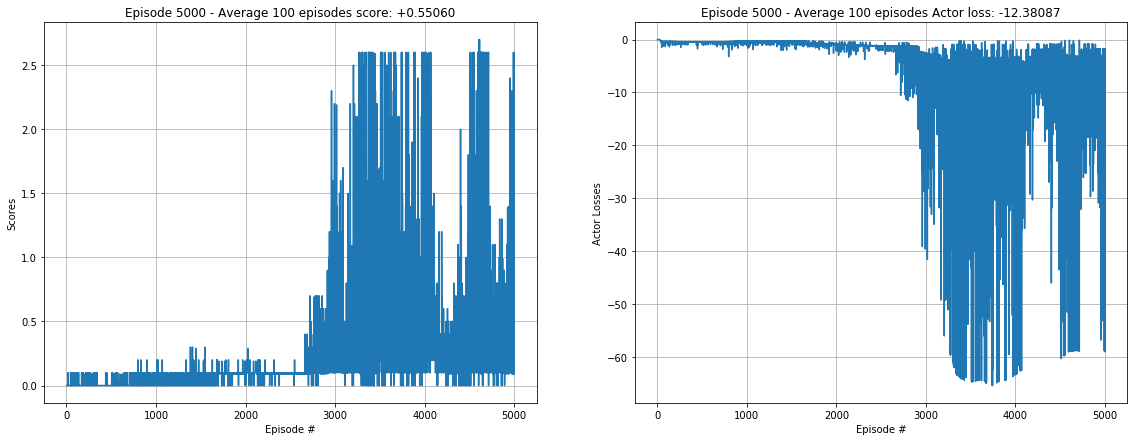

Environment resolved in 5000 episodes!
Model used ->  agent_model_trained_20181206_090313.pth

Environment tested in 883.8483757217725 minutes!

Model total score obtained -> 1413.9900212846696


In [13]:
training_mode = True

if training_mode == True:
    
    # echoes current task
    print("Training started... :-)")
    
    # instantiates a new environment in test mode
    env = UnityEnvironment(file_name='Tennis.app', no_graphics=True, seed=0)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]

    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])
    
    # starts our tests
    train()

In [14]:
def test(number_of_episodes=300, number_of_steps=300, average_score_episodes=100, print_every_episodes=1):
    
    # last 100 episodes average score
    last_100_episodes_scores = deque(maxlen = average_score_episodes)
    
    # scores bookkeeping
    scores_log = []

    # instantiates the agent in test mode
    agents_handler = AgentsHandler(num_agents, state_size, action_size)
    
    # loads the model into the critic network
    agents_handler.load_agent_model("agent_model_trained_20181205_081022.pth")

    step = 0
        
    for i_episode in range(1, number_of_episodes + 1):

        # reset the environment
        env_info = env.reset(train_mode = False)[brain_name]

        # get the current state of the environment (for each agent)
        states = env_info.vector_observations               # (num_agents x 24)

        # initialize the score (for each agent)
        episode_total_scores = np.zeros(num_agents)

        for step in range(1, number_of_steps + 1):
        
            # gets an action from the actor's network
            actions = agents_handler.act(states, step)      # (num_agents x 2)
            
            # takes a step in the environment
            env_info = env.step(actions)[brain_name]

            #  gets rewards, next_states and dones
            rewards = env_info.rewards                      # (num_agents x 1)
            next_states = env_info.vector_observations      # (num_agents x 24)
            dones = env_info.local_done                     # (num_agents x 1)

            # sets the next state
            states = next_states
            
            # updates the current episode's score (num_agents x 1)
            episode_total_scores += rewards

            # time to stop?
            if np.any(dones):
                #print("breaking episode {} at {}".format(i_episode, step))
                break
            
        # gets the episode score by retrieving the maximum score from all agents
        episode_score = np.max(episode_total_scores)
                
        # adds this episode average score to the complete scores log
        scores_log.append(episode_score)
        
        # adds to last 100 episodes
        last_100_episodes_scores.append(episode_score)
        
        # plots the latest 100 episodes average reward
        if i_episode % print_every_episodes == 0:
            plot_scores(i_episode, scores_log)
    
    # prints the last 100 episodes mean
    print("Final 100 episodes mean: {}".format(np.mean(last_100_episodes_scores)))
    
    # closes the environment
    env.close()

In [15]:
testing_mode = False

if testing_mode == True:
    
    # echoes current task
    print("Testing started... :-)")
    
    # instantiates a new environment in test mode
    env = UnityEnvironment(file_name='Tennis.app', no_graphics=False, seed=0)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]

    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])
    
    # starts our tests
    test()

In [16]:
random.randint(1,1000)

773

In [17]:
states = torch.rand(1, 2, 24)
print(states)

states = states.view(-1, 48)
print(states)
print(states.size())
#states.squeeze(2)
#print(states)

tensor([[[ 0.8845,  0.2333,  0.2930,  0.1083,  0.9507,  0.4174,  0.8332,
           0.9910,  0.0379,  0.1811,  0.3680,  0.1928,  0.1728,  0.0014,
           0.8649,  0.0914,  0.0761,  0.6056,  0.4285,  0.7188,  0.5959,
           0.9635,  0.6575,  0.3764],
         [ 0.1559,  0.9186,  0.1072,  0.0846,  0.9475,  0.6054,  0.4789,
           0.6369,  0.7980,  0.6933,  0.9934,  0.6030,  0.5273,  0.1951,
           0.2402,  0.6590,  0.8005,  0.0788,  0.5029,  0.6019,  0.4757,
           0.9037,  0.6433,  0.2006]]])
tensor([[ 0.8845,  0.2333,  0.2930,  0.1083,  0.9507,  0.4174,  0.8332,
          0.9910,  0.0379,  0.1811,  0.3680,  0.1928,  0.1728,  0.0014,
          0.8649,  0.0914,  0.0761,  0.6056,  0.4285,  0.7188,  0.5959,
          0.9635,  0.6575,  0.3764,  0.1559,  0.9186,  0.1072,  0.0846,
          0.9475,  0.6054,  0.4789,  0.6369,  0.7980,  0.6933,  0.9934,
          0.6030,  0.5273,  0.1951,  0.2402,  0.6590,  0.8005,  0.0788,
          0.5029,  0.6019,  0.4757,  0.9037,  0.6433

In [18]:
actions = np.ones((5, 2))
print(actions)
print(actions.shape)
noise = np.ones(2,) * random.randint(1,1000)
print(noise)
print(noise.shape)
print(actions+noise)


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
(5, 2)
[247. 247.]
(2,)
[[248. 248.]
 [248. 248.]
 [248. 248.]
 [248. 248.]
 [248. 248.]]


In [19]:
a = np.array([[1,2,3], [1,2,3]])
print(a)
print(a.shape)

[[1 2 3]
 [1 2 3]]
(2, 3)
